In [14]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [19]:
def compute_avg_l2_distance_from_mean(epoch: int, layer_name: str, base_path: str):
    layer_dir = os.path.join(
        base_path,
        f"grad_info_per_epoch",
        f"epoch{epoch}",
        layer_name
    )

    grad_list = []
    filenames = sorted([
        f for f in os.listdir(layer_dir) if f.endswith(".pt")
    ])

    for fname in filenames:
        grad = torch.load(os.path.join(layer_dir, fname))  # [D]
        grad_list.append(grad)

    grads = torch.stack(grad_list)  # [T, D]
    grad_mean = grads.mean(dim=0)

    l2_dists = [torch.norm(g - grad_mean, p=2).item() for g in grads]
    avg_l2_dist = sum(l2_dists) / len(l2_dists)
    
    print(f"{layer_name} (epoch {epoch}): Avg L2 distance from mean = {avg_l2_dist:.4f}")
    
    return avg_l2_dist


def compute_avg_l2_distance_over_epochs(layer_name: str, base_path: str, epoch_list: list):
    results = {}
    for epoch in epoch_list:
        try:
            avg_l2 = compute_avg_l2_distance_from_mean(epoch, layer_name, base_path)
            results[epoch] = avg_l2
        except Exception as e:
            print(f"[Warning] Epoch {epoch} failed: {e}")
    return results


def plot_l2_distance_from_mean_layerwise_subplots(
    maml_base_path: str,
    our_base_path: str,
    epoch_list: list
):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]

    num_layers = len(layer_names)
    nrows = (num_layers + 1) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 3 * nrows))
    axes = axes.flatten()

    for idx, layer_name in enumerate(layer_names):
        ax = axes[idx]

        maml_results = compute_avg_l2_distance_over_epochs(layer_name, maml_base_path, epoch_list)
        our_results = compute_avg_l2_distance_over_epochs(layer_name, our_base_path, epoch_list)

        sorted_epochs = sorted(epoch_list)
        maml_values = [maml_results.get(ep, None) for ep in sorted_epochs]
        our_values = [our_results.get(ep, None) for ep in sorted_epochs]

        ax.plot(sorted_epochs, maml_values, label="MAML", linestyle='dashed')
        ax.plot(sorted_epochs, our_values, label="OURS", linestyle='solid')

        ax.set_title(layer_name, fontsize=10)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Avg L2 Distance")
        ax.grid(True)
        ax.legend(fontsize=8)
        ax.set_xticks(sorted(epoch_list))

    # 여분 subplot 제거
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
def plot_and_save_l2_distance_layerwise_individual(
    maml_base_path: str,
    our_base_path: str,
    epoch_list: list,
    save_dir: str = "gradient/l2_distance"
):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]

    os.makedirs(save_dir, exist_ok=True)

    for layer_name in layer_names:
        # 데이터 수집
        maml_results = compute_avg_l2_distance_over_epochs(layer_name, maml_base_path, epoch_list)
        our_results = compute_avg_l2_distance_over_epochs(layer_name, our_base_path, epoch_list)

        sorted_epochs = sorted(epoch_list)
        maml_values = [maml_results.get(ep, None) for ep in sorted_epochs]
        our_values = [our_results.get(ep, None) for ep in sorted_epochs]

        # 그래프 그리기
        plt.figure(figsize=(8, 5))
        plt.plot(sorted_epochs, maml_values, label="MAML", linestyle='dashed')
        plt.plot(sorted_epochs, our_values, label="OURS", linestyle='solid')

        plt.title(f"L2 Distance to Mean - {layer_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Avg L2 Distance")
        plt.grid(True)
        plt.legend()
        plt.xticks(sorted(epoch_list))
        plt.tight_layout()

        # 저장
        filename = f"{layer_name}_l2_distance.png"
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path, dpi=300)
        plt.close()

        print(f"[Saved] {save_path}")

layer_layer_dict_conv0_conv_weight (epoch 0): Avg L2 distance from mean = 2.3043
layer_layer_dict_conv0_conv_weight (epoch 1): Avg L2 distance from mean = 3.5658
layer_layer_dict_conv0_conv_weight (epoch 2): Avg L2 distance from mean = 3.3471
layer_layer_dict_conv0_conv_weight (epoch 0): Avg L2 distance from mean = 2.2538
layer_layer_dict_conv0_conv_weight (epoch 1): Avg L2 distance from mean = 1.8805
layer_layer_dict_conv0_conv_weight (epoch 2): Avg L2 distance from mean = 3.2000
layer_layer_dict_conv1_conv_weight (epoch 0): Avg L2 distance from mean = 1.3812
layer_layer_dict_conv1_conv_weight (epoch 1): Avg L2 distance from mean = 1.1604
layer_layer_dict_conv1_conv_weight (epoch 2): Avg L2 distance from mean = 1.0390
layer_layer_dict_conv1_conv_weight (epoch 0): Avg L2 distance from mean = 1.8102
layer_layer_dict_conv1_conv_weight (epoch 1): Avg L2 distance from mean = 0.9275
layer_layer_dict_conv1_conv_weight (epoch 2): Avg L2 distance from mean = 1.0418
layer_layer_dict_conv2_conv_

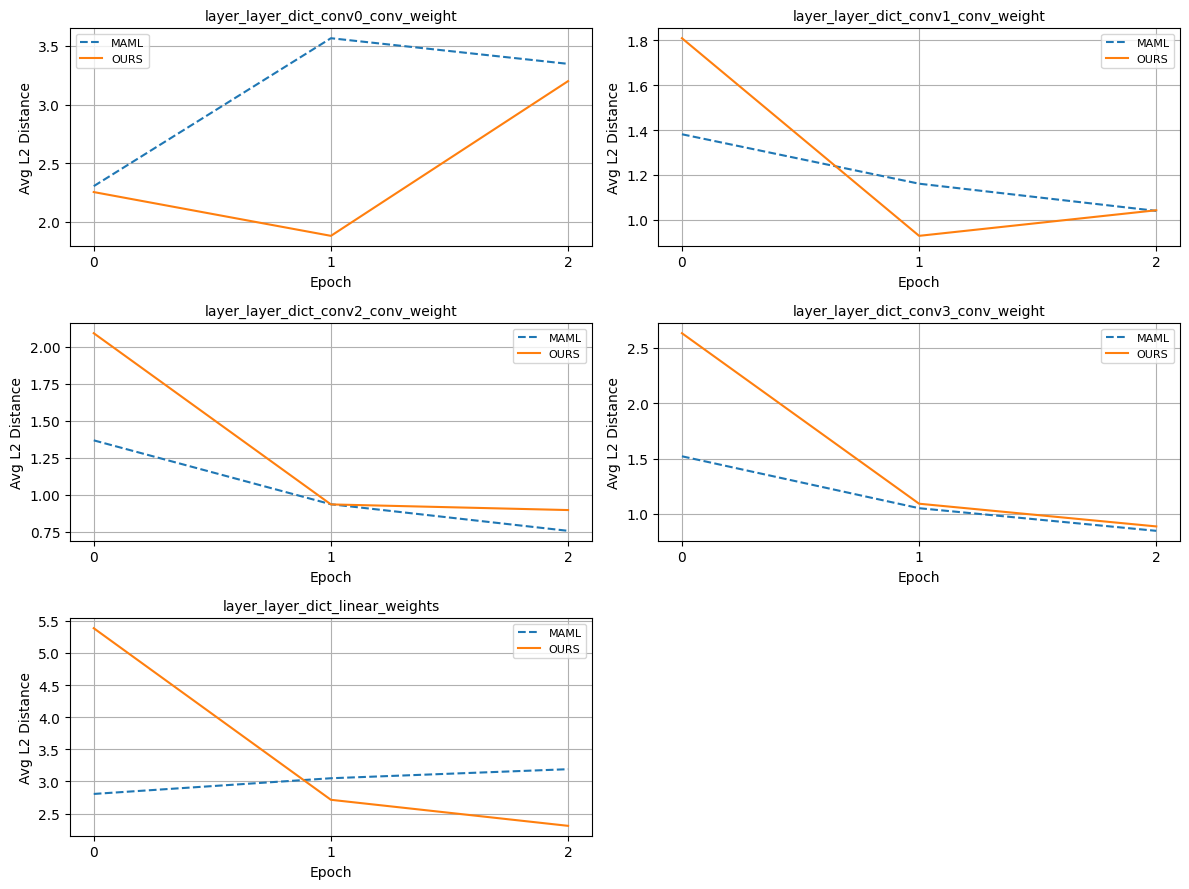

In [18]:
maml_base_path = "../MAML_5way_5shot_filter64_miniImagenet"
our_base_path = "../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet"
epoch_list = list(range(0, 3))

plot_l2_distance_from_mean_layerwise_subplots(maml_base_path, our_base_path, epoch_list)

In [20]:
plot_and_save_l2_distance_layerwise_individual(maml_base_path, our_base_path, epoch_list)

layer_layer_dict_conv0_conv_weight (epoch 0): Avg L2 distance from mean = 2.3043
layer_layer_dict_conv0_conv_weight (epoch 1): Avg L2 distance from mean = 3.5658
layer_layer_dict_conv0_conv_weight (epoch 2): Avg L2 distance from mean = 3.3471
layer_layer_dict_conv0_conv_weight (epoch 0): Avg L2 distance from mean = 2.2538
layer_layer_dict_conv0_conv_weight (epoch 1): Avg L2 distance from mean = 1.8805
layer_layer_dict_conv0_conv_weight (epoch 2): Avg L2 distance from mean = 3.2000
[Saved] gradient/l2_distance\layer_layer_dict_conv0_conv_weight_l2_distance.png
layer_layer_dict_conv1_conv_weight (epoch 0): Avg L2 distance from mean = 1.3812
layer_layer_dict_conv1_conv_weight (epoch 1): Avg L2 distance from mean = 1.1604
layer_layer_dict_conv1_conv_weight (epoch 2): Avg L2 distance from mean = 1.0390
layer_layer_dict_conv1_conv_weight (epoch 0): Avg L2 distance from mean = 1.8102
layer_layer_dict_conv1_conv_weight (epoch 1): Avg L2 distance from mean = 0.9275
layer_layer_dict_conv1_conv_w